# Prediksi Harga Saham Google Menggunakan LSTM

## Import library

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers
from datetime import datetime
import matplotlib.dates as mdates
import seaborn as sns

## Data loading

In [3]:
train_dataset = pd.read_csv("Google_Stock_Price_Train.csv")
test_dataset = pd.read_csv("Google_Stock_Price_Test.csv")
train_dataset.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [5]:
train_dataset['Date'] = pd.to_datetime(train_dataset['Date'])
train_dataset['Close'] = train_dataset['Close'].str.replace(',','').astype(float)
train_dataset['Volume'] = train_dataset['Volume'].str.replace(',','').astype(float)

In [6]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   float64       
 5   Volume  1258 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 59.1 KB


## Exploratory Data Analysis

### Analisis Tren Harga Saham

C:\Users\frend\AppData\Local\Temp\ipykernel_2232\1565986413.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


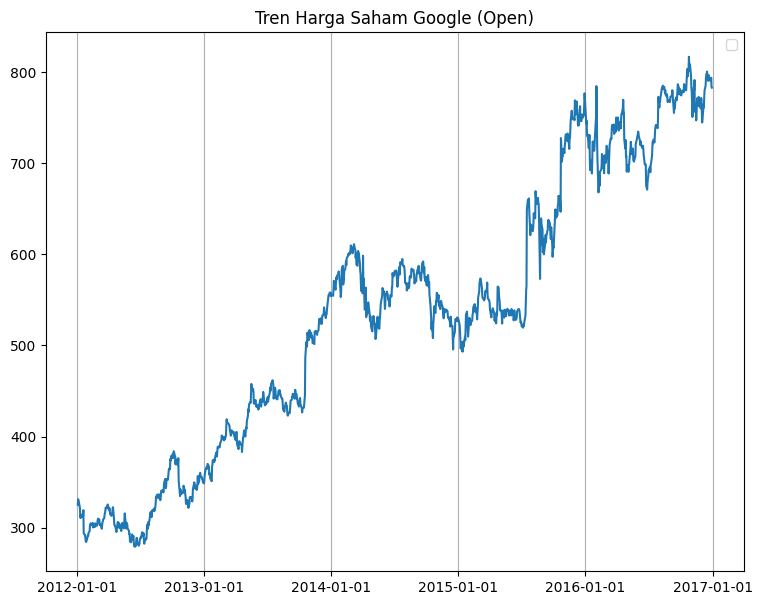

In [7]:
plt.figure(figsize=(9, 7))
plt.plot(train_dataset["Date"], train_dataset["Open"])
plt.title("Tren Harga Saham Google (Open)")
pos = mdates.YearLocator()
fmt = mdates.DateFormatter('%Y-%m-%d') 
plt.gca().xaxis.set(major_locator=pos, major_formatter=fmt)
plt.grid(axis='x')
plt.legend()
plt.show()

### Analisis Korelasi Fitur

<Axes: >

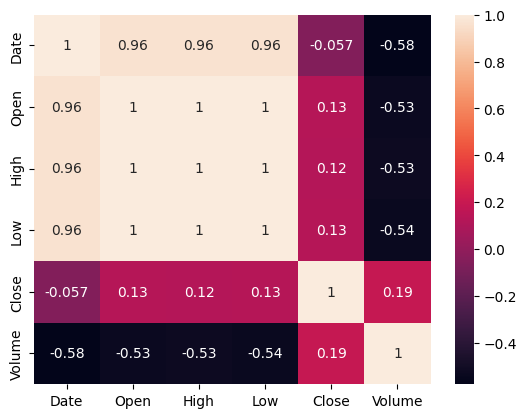

In [8]:
corr_matrix = train_dataset.corr()
sns.heatmap(corr_matrix, annot=True)

### Analisis Outlier

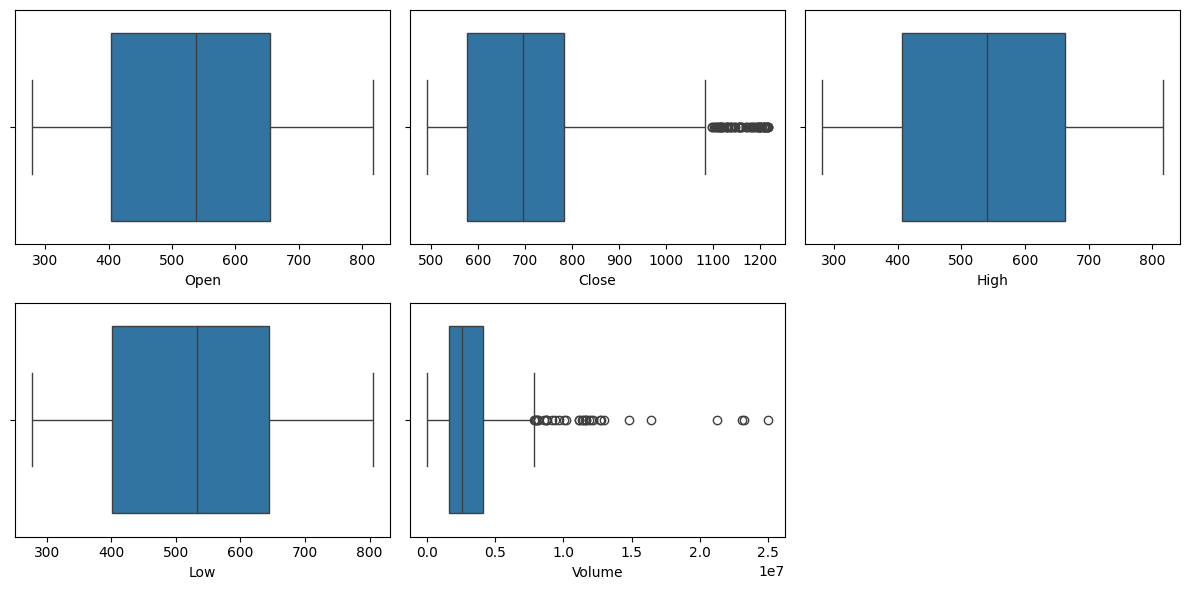

In [15]:
fig, ax = plt.subplots(figsize=(12,6), nrows=2, ncols=3)
ax = ax.flatten()
sns.boxplot(x=train_dataset["Open"], ax=ax[0])
sns.boxplot(x=train_dataset["Close"], ax=ax[1])
sns.boxplot(x=train_dataset["High"], ax=ax[2])
sns.boxplot(x=train_dataset["Low"], ax=ax[3])
sns.boxplot(x=train_dataset["Volume"], ax=ax[4])

for i in range(5, len(ax)):
    fig.delaxes(ax[i])
    
plt.tight_layout()
plt.show()

## Data Preprocessing

### Memilih kolom 'Open' untuk proses pelatihan dan prediksi

In [17]:
train_set = train_dataset.iloc[:, 1:2].values
print(type(train_set))
display(train_set)
train_set.shape

<class 'numpy.ndarray'>


array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

(1258, 1)

### Scaling fitur

In [20]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set)

train_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

### Membentuk sequence data tiap 60 hari

In [21]:
X_train = []
y_train = []

for i in range(60, train_scaled.shape[0]):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(1198, 60)

### Reshaping data ke bentuk 3D agar sesuai dengan input yang dibutuhkan LSTM

In [22]:
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1198, 60, 1)

## Modelling

In [23]:
rnn = tf.keras.Sequential([
    layers.Input(shape=(X_train.shape[1], 1)),
    layers.LSTM(units=50, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(units=50, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(units=50, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(units=50),
    layers.Dropout(0.2),
    layers.Dense(units=1)
])

In [24]:
rnn.compile(optimizer="adam", loss="mean_squared_error", metrics=["r2_score"])

In [25]:
rnn.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 0.0777 - r2_score: -0.0540
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - loss: 0.0064 - r2_score: 0.9145
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - loss: 0.0051 - r2_score: 0.9325
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - loss: 0.0052 - r2_score: 0.9318 
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - loss: 0.0048 - r2_score: 0.9377
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - loss: 0.0044 - r2_score: 0.9387
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - loss: 0.0044 - r2_score: 0.9384
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 0.0046 - r2_score: 0.9358
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - loss: 0.0054 - r2_score: 0.9277
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - loss: 0.0053 - r2_score: 0.9282
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - loss: 0.0035 - r2_score: 0.9534
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━

## Model Evaluation

In [26]:
all_data = pd.concat((train_dataset['Open'], test_dataset['Open']), axis=0)

test_set = all_data[len(all_data) - len(test_dataset) - 60:].values
test_set = test_set.reshape(-1,1)

test_set = scaler.transform(test_set)

print(test_set.shape)
print(test_set)

(80, 1)
[[0.9299055 ]
 [0.93113327]
 [0.92750577]
 [0.94415507]
 [0.93876032]
 [0.93403527]
 [0.93483518]
 [0.9313937 ]
 [0.94636878]
 [0.96569685]
 [0.97510976]
 [0.95966962]
 [0.97808617]
 [1.        ]
 [0.98076494]
 [0.97083116]
 [0.98450406]
 [0.96054394]
 [0.9371419 ]
 [0.92841729]
 [0.90804747]
 [0.8771858 ]
 [0.92153434]
 [0.93809063]
 [0.93165414]
 [0.95254483]
 [0.88812412]
 [0.88637547]
 [0.87032145]
 [0.88563137]
 [0.90743359]
 [0.91571173]
 [0.89941588]
 [0.91805566]
 [0.9089404 ]
 [0.9024853 ]
 [0.89456061]
 [0.91600938]
 [0.9132934 ]
 [0.88979835]
 [0.86589404]
 [0.89030062]
 [0.90335962]
 [0.89642086]
 [0.91777662]
 [0.93176576]
 [0.94114145]
 [0.95762334]
 [0.96413424]
 [0.96402262]
 [0.96971501]
 [0.95077759]
 [0.96294367]
 [0.96123223]
 [0.95475854]
 [0.95204256]
 [0.95163331]
 [0.95725128]
 [0.93796041]
 [0.93688146]
 [0.92955205]
 [0.94731751]
 [0.94307612]
 [0.96015329]
 [0.98087655]
 [0.98359253]
 [0.97827219]
 [0.98225314]
 [0.98288563]
 [0.98214153]
 [0.979779  

In [27]:
X_test = []

for i in range(60, test_set.shape[0]):
    X_test.append(test_set[i-60:i, 0])
X_test = np.array(X_test)
X_test.shape

(20, 60)

In [28]:
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(20, 60, 1)

In [29]:
prediction = rnn.predict(X_test)
prediction = scaler.inverse_transform(prediction)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[790.4709 ],
       [787.6055 ],
       [787.6162 ],
       [788.72833],
       [791.911  ],
       [797.7539 ],
       [803.19415],
       [805.5134 ],
       [805.9427 ],
       [805.63495],
       [805.22156],
       [804.81934],
       [804.6145 ],
       [805.24725],
       [806.3925 ],
       [811.2638 ],
       [818.4211 ],
       [826.1122 ],
       [830.3486 ],
       [826.2725 ]], dtype=float32)

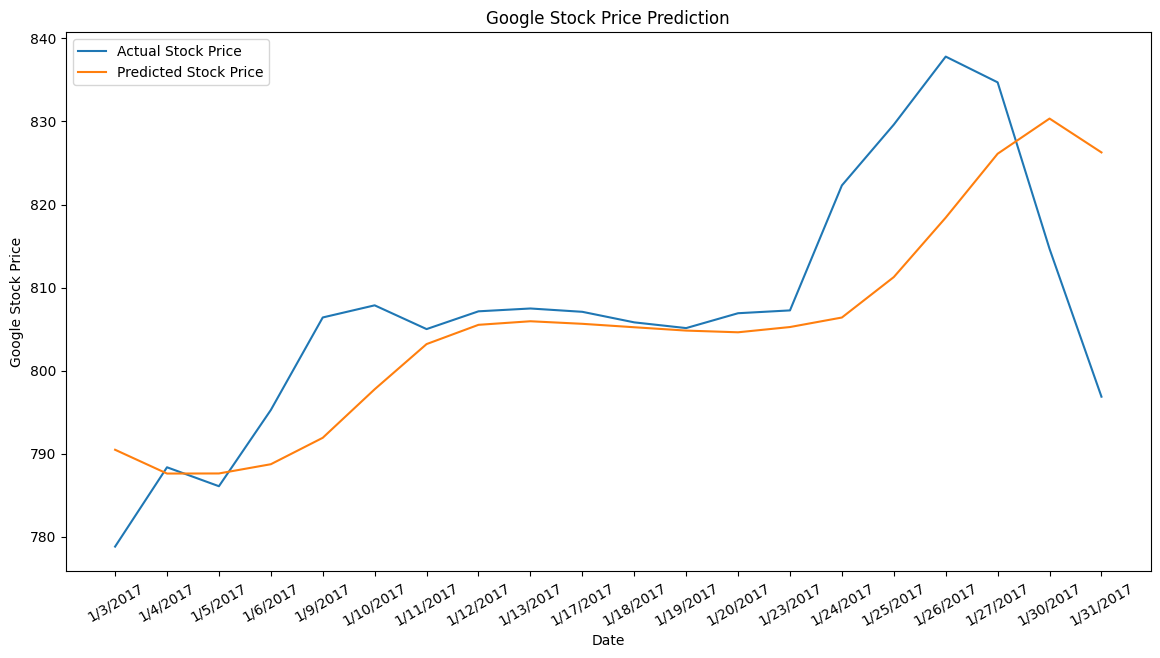

In [30]:
prediction = prediction.flatten()

plt.figure(figsize=(14, 7))
plt.plot(test_dataset["Date"], test_dataset["Open"], label="Actual Stock Price")
plt.plot(prediction, label="Predicted Stock Price")
plt.legend()
plt.ylabel("Google Stock Price")
plt.xlabel("Date")
plt.title("Google Stock Price Prediction")
plt.xticks(rotation=30)
plt.show()

In [40]:
real_stock_price = test_dataset.iloc[:, 1:2].values
real_stock_price = real_stock_price.flatten()

mse = mean_squared_error(real_stock_price, prediction)
r2 = r2_score(real_stock_price, prediction)

print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.4f}")

MSE: 133.24
R² Score: 0.3870
